In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.anova import anova_lm
from stargazer.stargazer import Stargazer

from IPython.display import display, HTML
display(HTML("<style>.container {width:85%;}</style>"))

# Investigating heteroscedasticity

| Assumption      | Impact of violation                                                                                                           |
|-----------------|------------------------------------------------------------------------------------------------------------------|
| Homoscedasticity| "Estimates may still be unbiased, but they are no longer the most efficient ones.                              |
|                 | As a result, the standard errors of the coefficients are unreliable, leading to incorrect statistical inferences,such as inaccurate p-values, confidence intervals, and hypothesis tests."                                      |


## Causes of heteroscedasticity
| Cause                           | Explanation                                                                                                      |
|---------------------------------|------------------------------------------------------------------------------------------------------------------|
| Omitted Variables               | When important variables are left out of the regression model, their effects may manifest in varying residuals, leading to heteroscedasticity.                           |
| Data Transformation Issues      | Improper data transformations, such as logarithm or square root of variables, can introduce heteroscedasticity.    |
| Measurement Errors              | Inaccuracies in measuring variables can contribute to heteroscedasticity, especially if errors vary across data points. |
| Outliers                        | Extreme values in the data can disproportionately influence the variability of residuals, leading to heteroscedasticity. |
| Heterogeneous Groups            | Data with distinct groups having different underlying relationships between variables can lead to heteroscedasticity. |
| Time Trends                     | Variance changes over time in time series data can indicate heteroscedasticity due to changing volatility or dispersion. |
| Interaction Effects             | Interactions between independent variables can cause varying residuals and, hence, heteroscedasticity.          |
| Nonlinear Relationships         | Nonlinear relationships between variables can lead to varying residuals across the predictor range.              |
| Sample Selection Bias           | Heteroscedasticity may arise when data is non-randomly sampled, leading to over- or under-representation of subgroups.|


## Data

In [3]:
selct_columns = ['lwage', 'exper', 'expersq', 'educ',  'age', 'kidslt6', 'kidsge6']
df = (
    pd.read_stata('http://fmwww.bc.edu/ec-p/data/wooldridge/mroz.dta')
    .filter(selct_columns)
    .dropna()
    .assign(educgr = lambda X: pd.cut(X["educ"], bins = [5,11,13, 18], labels=('Diploma','Degree','Masters'), ordered=True))
)

## Model

In [4]:
olsModel = smf.ols(formula = 'lwage ~ exper + expersq + educ + age + kidslt6 + kidsge6', data=df).fit()

print(olsModel.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     13.19
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           1.06e-13
Time:                        22:34:36   Log-Likelihood:                -431.24
No. Observations:                 428   AIC:                             876.5
Df Residuals:                     421   BIC:                             904.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4209      0.317     -1.328      0.1

## Testing for homoscedasticity - graphically

In [5]:
from pynometrics.pynometrics import mplot

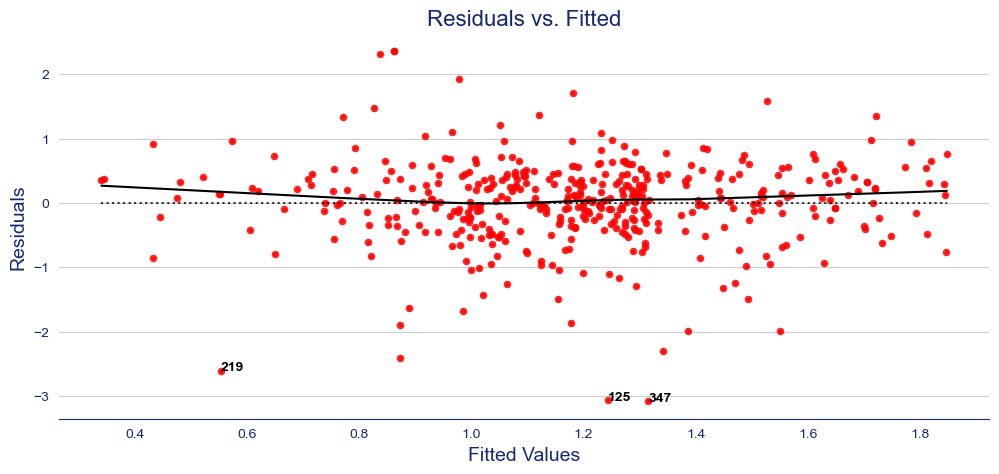

In [7]:
mplot_init = mplot(olsModel)
mplot_init.plot(1)

### Using the Breusch-Pagan test 

In [8]:
testResults = sms.het_breuschpagan(olsModel.resid, olsModel.model.exog)

pd.DataFrame(testResults, index=["Lagrange multiplier statistic", "Lagrange p-value", "f-value", "f p-value"]).T

,Lagrange multiplier statistic,Lagrange p-value,f-value,f p-value
0,15.729136,0.015284,2.677029,0.014651


| Lagrange p-value | Interpretation                                                                                  |
|------------------|--------------------------------------------------------------------------------------------------|
|                 | Reject H0 (assumption of homoscedasticity) if Lagrange p-value is less than the significance level and conclude that there is heteroscedasticity at the significance level                        |


## Dealing with heteroscedasticity

### Robust standard errors

In [13]:
olsModel_robust = smf.ols(formula = 'lwage ~ exper + expersq + educ + age + kidslt6 + kidsge6', data=df)

olsModel_robust = olsModel_robust.fit(cov_type="HC3")

print(olsModel_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     13.38
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           6.74e-14
Time:                        23:37:50   Log-Likelihood:                -431.24
No. Observations:                 428   AIC:                             876.5
Df Residuals:                     421   BIC:                             904.9
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4209      0.322     -1.306      0.1

### Weighted Least Squares (WLS)/Generalized least squares (GLS)

In [17]:
df_weights = pd.DataFrame({'residuals':abs(olsModel.resid), 'fitted':olsModel.fittedvalues})

model_weights = smf.ols('residuals ~ fitted', data = df_weights).fit().fittedvalues.values

model_weights = 1/(model_weights **2)

wlsModel = smf.wls('lwage ~ exper + expersq + educ + age + kidslt6 + kidsge6', data = df, weights=model_weights)
wlsModel = wlsModel.fit()

print(wlsModel.summary())

                            WLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.169
Model:                            WLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     14.31
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           7.29e-15
Time:                        23:58:16   Log-Likelihood:                -428.55
No. Observations:                 428   AIC:                             871.1
Df Residuals:                     421   BIC:                             899.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3709      0.315     -1.179      0.2

### Checking for influential observations

| Check          | Description                                                                                             | Interpretation                                                                                            |
|----------------|---------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| Cook's distance | Measures how much all the fitted values change when a given observation is deleted\n\nA data point with high cook's distance indicates that the data point strong influences the fitted values | if the cook's distance is more than 0.5, the data point might be influential\n\nif the cook's distance stands out more than the other cook's distances, then it is almost certain that it is influential. |

#### Cook's distance

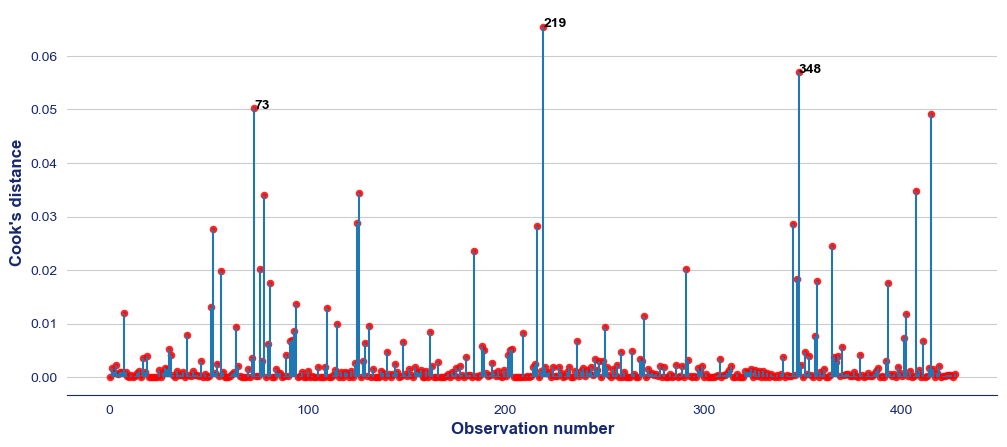

In [19]:
mplot_init = mplot(olsModel)
mplot_init.plot(4)

#### Leverage

| Check          | Description                                                                                             | Interpretation                                                                                            |
|----------------|---------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| Leverage       | Refers to the extent to which the coefficients of the regression model would change if a particular observation was removed from the dataset.\n\nObservations with high leverage have strong influence on the coefficients in the regression model, removing these observations might change the coefficients of the model considerably | From the residuals vs leverage points, points that fall outside the cook's distance (red dotted line) are considered to be influential observations |


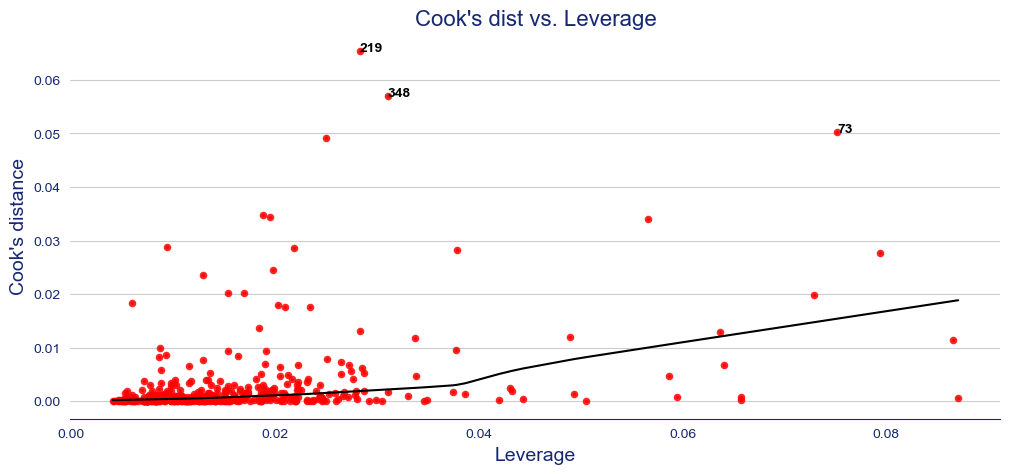

In [20]:
mplot_init = mplot(olsModel)
mplot_init.plot(6)